07.02.23

# Analyse slices annotated by experts

- Open, organise and analyse the slices that have been annotated by the experts.
- Compute some metrics to get inter-observer variability

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
#import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import warnings
import scipy

#from skimage.io import imsave

from in_out_tools import load_movies_ids, load_annotations_ids
from metrics_tools import compute_iou, empty_marginal_frames
from data_processing_tools import get_processed_result, class_to_nb, dict_to_int_mask

## Load slices annotated by experts

In [16]:
slices_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
#slices_ids = ['01', '02', '03', '05', '06', '07', '09', '10']

#expert_ids = ['RJ', 'ME', 'NS', 'EN', 'MW', 'MF', 'CS']
expert_ids = ['RJ', 'ME', 'EN', 'NS', 'MW']

# make expert ids anonymous
anon_ids = {expert_id: 'expert_' + str(i) for i, expert_id in enumerate(expert_ids)}
anon_ids_list = list(anon_ids.values())


dir = r'C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices'

In [17]:
# Load all .tif files and save them in a dictionary
# Dictionary are indexed by the slice id and the expert id
all_segmentations = dict.fromkeys(anon_ids_list+['ground_truth','unet_preds'])

In [18]:
for expert_id in expert_ids:
    all_segmentations[anon_ids[expert_id]] = dict.fromkeys(slices_ids)
    for slice_id in slices_ids:
        all_segmentations[anon_ids[expert_id]][slice_id] = imageio.volread(os.path.join(dir, 
                                                                      expert_id, 
                                                                      'sample'+slice_id+'.tif'))

## Load corresponding slices in annotated dataset and UNet predictions

In [19]:
slice_to_movie_id = {'01': '15',
                     '02': '20',
                     '03': '34',
                     '04': '05',
                     '05': '10',
                     '06': '25',
                     '07': '32',
                     '08': '34',
                     '09': '40',
                     '10': '45'}

slice_to_frame_id = {'01': 54-1,
                     '02': 445-1,
                     '03': 430-1,
                     '04': 351-1,
                     '05': 410-1,
                     '06': 109-1,
                     '07': 950-1,
                     '08': 894-1,
                     '09': 898-1,
                     '10': 667-1}

### Load annotated dataset

In [20]:
dataset_dir = os.path.join("..", "data", "sparks_dataset")

In [21]:
all_segmentations['ground_truth'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['ground_truth'][slice_id] = np.asarray(imageio.volread(os.path.join(
                                                    dataset_dir,
                                                    (movie_id+'_class_label.tif'))))[frame_id]

### Load predicted segmentation

In [22]:
movie_ids = ["05","10","15","20","25","32","34","40","45"]

In [23]:
training_name = 'TEMP_new_annotated_peaks_physio'
epoch = 100000

preds_dir = os.path.join("trainings_validation", training_name)

In [24]:
### Load movies
xs = load_movies_ids(data_folder=dataset_dir,
                     ids=movie_ids,
                     names_available=True,
                     movie_names="video")

### Load predictions
sparks_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_waves.tif") for movie_id in movie_ids}

sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [25]:
# parameters necessary to process predictions

# physiological params (for spark peaks results)
pixel_size = 0.2 # 1 pixel = 0.2 um x 0.2 um
min_dist_xy = round(1.8 / pixel_size) # min distance in space
time_frame = 6.8 # 1 frame = 6.8 ms
min_dist_t = round(20 / time_frame) # min distance in time

# spark instances detection parameters
min_dist_xy = min_dist_xy
min_dist_t = min_dist_t
radius = math.ceil(min_dist_xy / 2)
y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
disk = x**2 + y**2 <= radius**2
conn_mask = np.stack([disk] * (min_dist_t), axis=0)

# connectivity for event instances detection
connectivity = 26
sigma = 3

# TODO: use better parameters !!!
pixel_size = 0.2
spark_min_width = 3
spark_min_t = 3
puff_min_t = 5
wave_min_width = round(15 / pixel_size)

# maximal gap between two predicted puffs or waves that belong together
max_gap = 2  # i.e., 2 empty frames

In [26]:
preds_segmentation = {}

for movie_id in movie_ids:
    _, preds, _ = get_processed_result(
            sparks=sparks[movie_id],
            puffs=puffs[movie_id],
            waves=waves[movie_id],
            xs=xs[movie_id],
            conn_mask=conn_mask,
            connectivity=connectivity,
            max_gap=max_gap,
            sigma=sigma,
            wave_min_width=wave_min_width,
            puff_min_t=puff_min_t,
            spark_min_t=spark_min_t,
            spark_min_width=spark_min_width,
        )
    preds_segmentation[movie_id] = dict_to_int_mask(preds)

In [27]:
all_segmentations['unet_preds'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['unet_preds'][slice_id] = preds_segmentation[movie_id][frame_id]

In [28]:
for slice_id in slices_ids:
    for annotator in all_segmentations.keys():
        print(f"Slice {slice_id} - {annotator}: {np.unique(all_segmentations[annotator][slice_id])}")

Slice 01 - expert_0: [0 3]
Slice 01 - expert_1: [0 3]
Slice 01 - expert_2: [0 3]
Slice 01 - expert_3: [0 1]
Slice 01 - expert_4: [0 3]
Slice 01 - ground_truth: [0 1 3]
Slice 01 - unet_preds: [0 1 3]
Slice 02 - expert_0: [0 1 3]
Slice 02 - expert_1: [0 1 3]
Slice 02 - expert_2: [0 1 2]
Slice 02 - expert_3: [0 2 3]
Slice 02 - expert_4: [0 1 3]
Slice 02 - ground_truth: [0 3]
Slice 02 - unet_preds: [0 1]
Slice 03 - expert_0: [0 1]
Slice 03 - expert_1: [0 1 3]
Slice 03 - expert_2: [0 1 3]
Slice 03 - expert_3: [0 1]
Slice 03 - expert_4: [0 1 3]
Slice 03 - ground_truth: [0 1 2]
Slice 03 - unet_preds: [0 1 3]
Slice 04 - expert_0: [0 1 3]
Slice 04 - expert_1: [0 1 3]
Slice 04 - expert_2: [0 1 3]
Slice 04 - expert_3: [0 1 3]
Slice 04 - expert_4: [0 1 3]
Slice 04 - ground_truth: [0 1 3]
Slice 04 - unet_preds: [0 1 3]
Slice 05 - expert_0: [0 3]
Slice 05 - expert_1: [0 3]
Slice 05 - expert_2: [0 2 3]
Slice 05 - expert_3: [0 2]
Slice 05 - expert_4: [0 1 3]
Slice 05 - ground_truth: [0 1 3]
Slice 05 -

In [29]:
from sklearn.metrics import cohen_kappa_score, jaccard_score

In [30]:
all_segmentations.keys()

dict_keys(['expert_0', 'expert_1', 'expert_2', 'expert_3', 'expert_4', 'ground_truth', 'unet_preds'])

In [31]:
warnings.filterwarnings('ignore')
# for each slice ID, compute inter-annotator agreement and store results in a dataframe
kappa_list = []
for slice_id in slices_ids:
    for annotator_1 in all_segmentations.keys():
        for annotator_2 in all_segmentations.keys():
            if annotator_1 != annotator_2:
                #print(f"A1: {annotator_1} - A2: {annotator_2} - Slice: {slice_id}")

                # compute jaccaard similarity for each class
                jaccard_0, jaccard_1, jaccard_2, jaccard_3 = jaccard_score(all_segmentations[annotator_1][slice_id].flatten(),
                                                                        all_segmentations[annotator_2][slice_id].flatten(),
                                                                        labels=[0,1,2,3],
                                                                        average=None)
                jaccard_average = np.mean([jaccard_1, jaccard_2, jaccard_3])


                kappa_list.append({'slice_id': slice_id,
                                   'annotator_1': annotator_1,
                                   'annotator_2': annotator_2,
                                   'kappa': cohen_kappa_score(all_segmentations[annotator_1][slice_id].flatten(),
                                                              all_segmentations[annotator_2][slice_id].flatten()),
                                   #'jaccard_sparks': jaccard_1,
                                   #'jaccard_puffs': jaccard_2,
                                   #'jaccard_waves': jaccard_3,
                                   #'jaccard_average': jaccard_average
                                   })

kappa_df = pd.DataFrame(kappa_list)

warnings.filterwarnings('default')

In [32]:
# remove entries in kappa_df where annotator_1 == ground_truth or annotator_2 == ground_truth
kappa_df_no_gt = kappa_df[(kappa_df.annotator_1 != 'ground_truth') & (kappa_df.annotator_2 != 'ground_truth')]


In [33]:
kappa_df

,slice_id,annotator_1,annotator_2,kappa
0,01,expert_0,expert_1,0.796058
1,01,expert_0,expert_2,0.253748
2,01,expert_0,expert_3,0.116472
3,01,expert_0,expert_4,0.604320
4,01,expert_0,ground_truth,0.527734
...,...,...,...,...
415,10,unet_preds,expert_1,0.577495
416,10,unet_preds,expert_2,0.854686
417,10,unet_preds,expert_3,0.754455
418,10,unet_preds,expert_4,0.830909


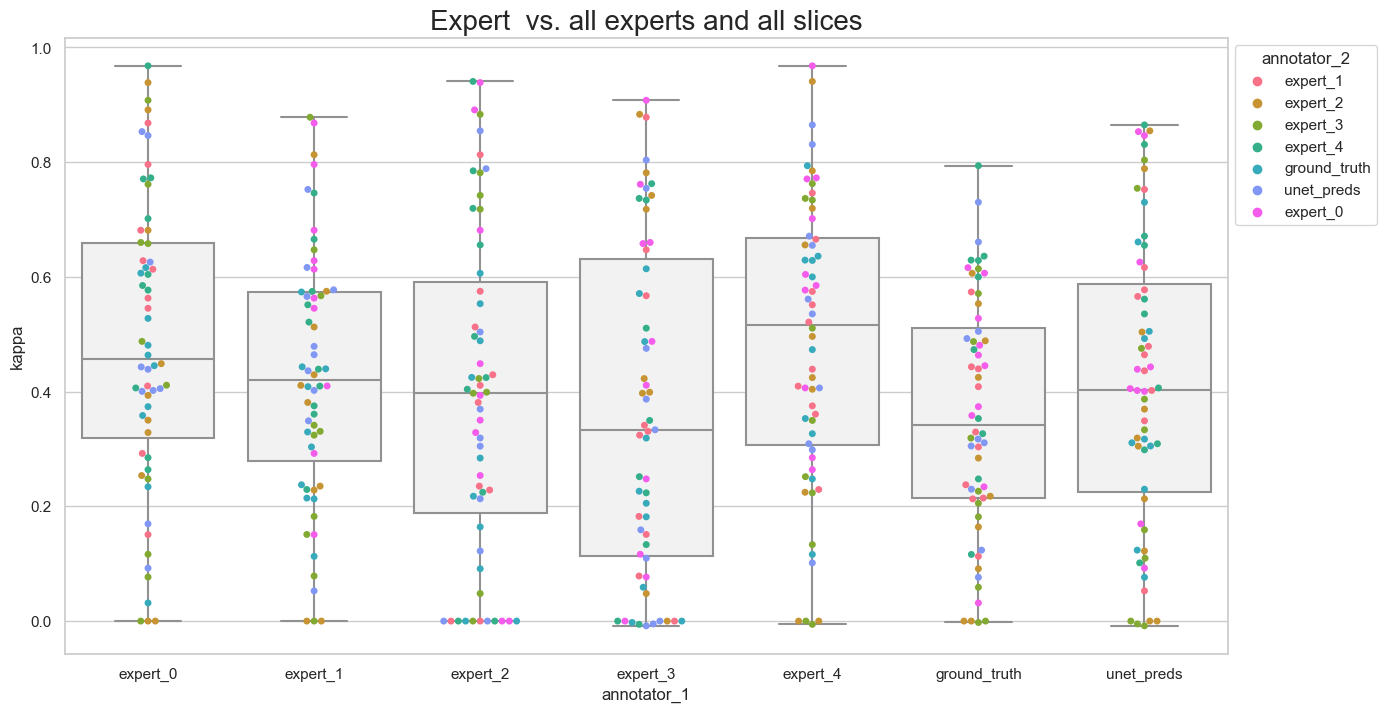

In [34]:
# visualize kappa values
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="annotator_1", y="kappa", data=kappa_df, color='.95')
ax = sns.swarmplot(x="annotator_1", y="kappa", data=kappa_df, hue="annotator_2", palette="husl")#, size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Expert  vs. all experts and all slices", fontsize=20)

plt.show()


In [35]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="annotator_1", y="jaccard_average", data=kappa_df, palette="Set3")
# ax = sns.swarmplot(x="annotator_1", y="jaccard_average", data=kappa_df, color=".5", size=3)

# plt.title("Expert  vs. all experts and all slices")

# plt.show()


Text(0.5, 1.0, 'Expert vs. all experts on each slice')

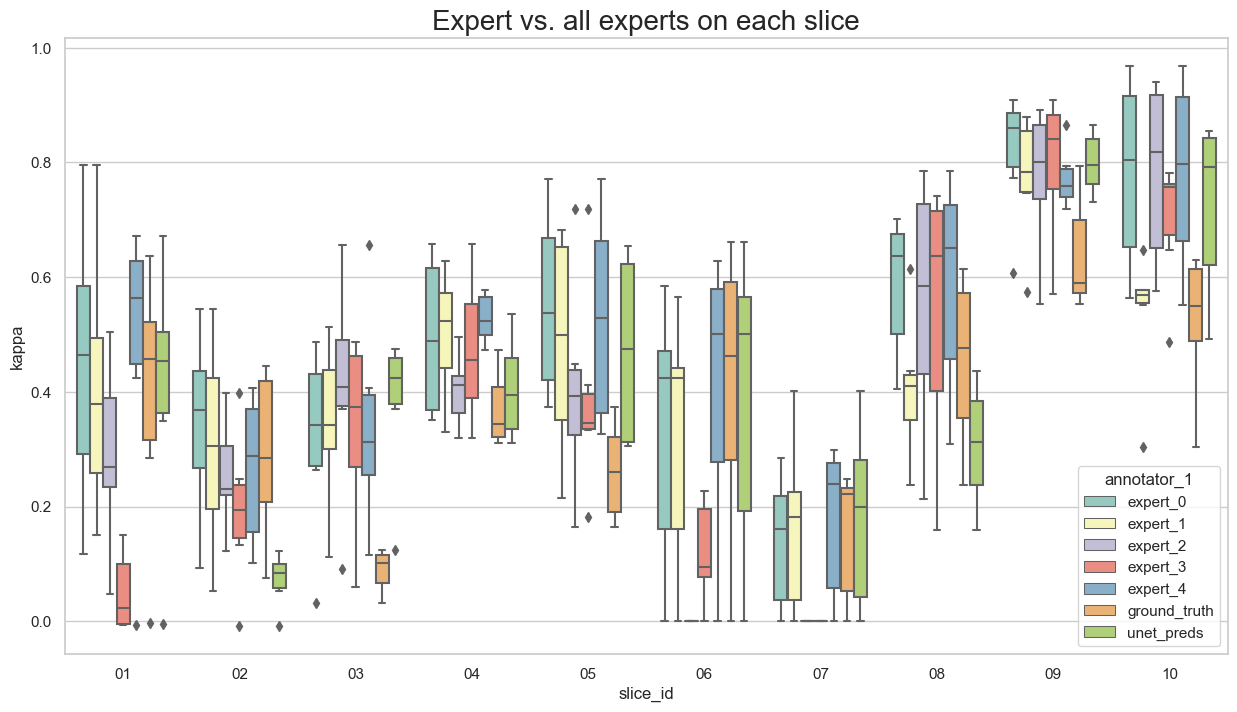

In [36]:
# visualize kappa values for each slice
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="slice_id", y="kappa", hue="annotator_1", data=kappa_df, palette="Set3")

plt.title("Expert vs. all experts on each slice", fontsize=20)

In [37]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values for each slice
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="slice_id", y="jaccard_average", hue="annotator_1", data=kappa_df, palette="Set3")

# plt.title("Expert vs. all experts on each slice")

Text(0.5, 1.0, 'Pairwise comparison of experts on all slices')

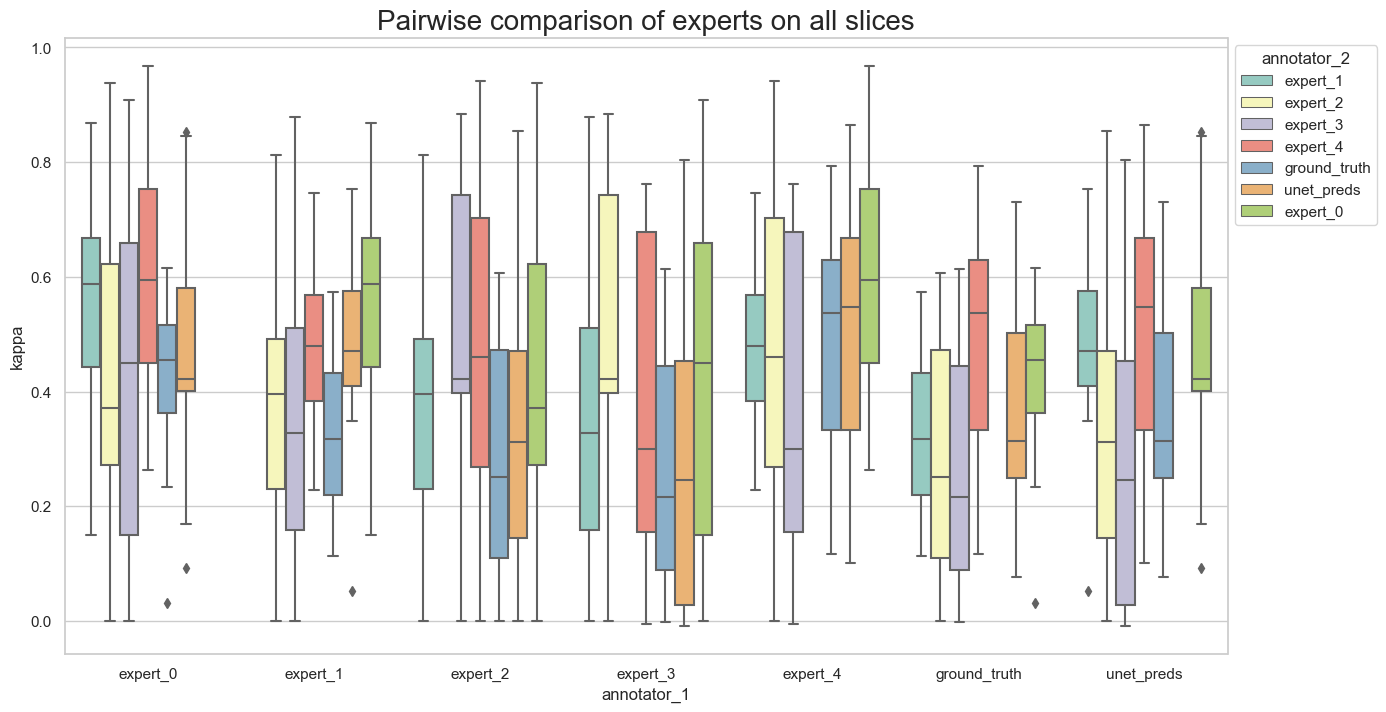

In [38]:
# visualize kappa values for each annotator
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="annotator_1", y="kappa", hue="annotator_2", data=kappa_df, palette="Set3")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Pairwise comparison of experts on all slices", fontsize=20)

In [39]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values for each annotator
# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(x="annotator_1", y="jaccard_average", hue="annotator_2", data=kappa_df)

[Text(0, 0.5, 'Expert 1'),
 Text(0, 1.5, 'Expert 2'),
 Text(0, 2.5, 'Expert 3'),
 Text(0, 3.5, 'Expert 4'),
 Text(0, 4.5, 'Expert 5'),
 Text(0, 5.5, 'Ground Truth'),
 Text(0, 6.5, 'UNet preds')]

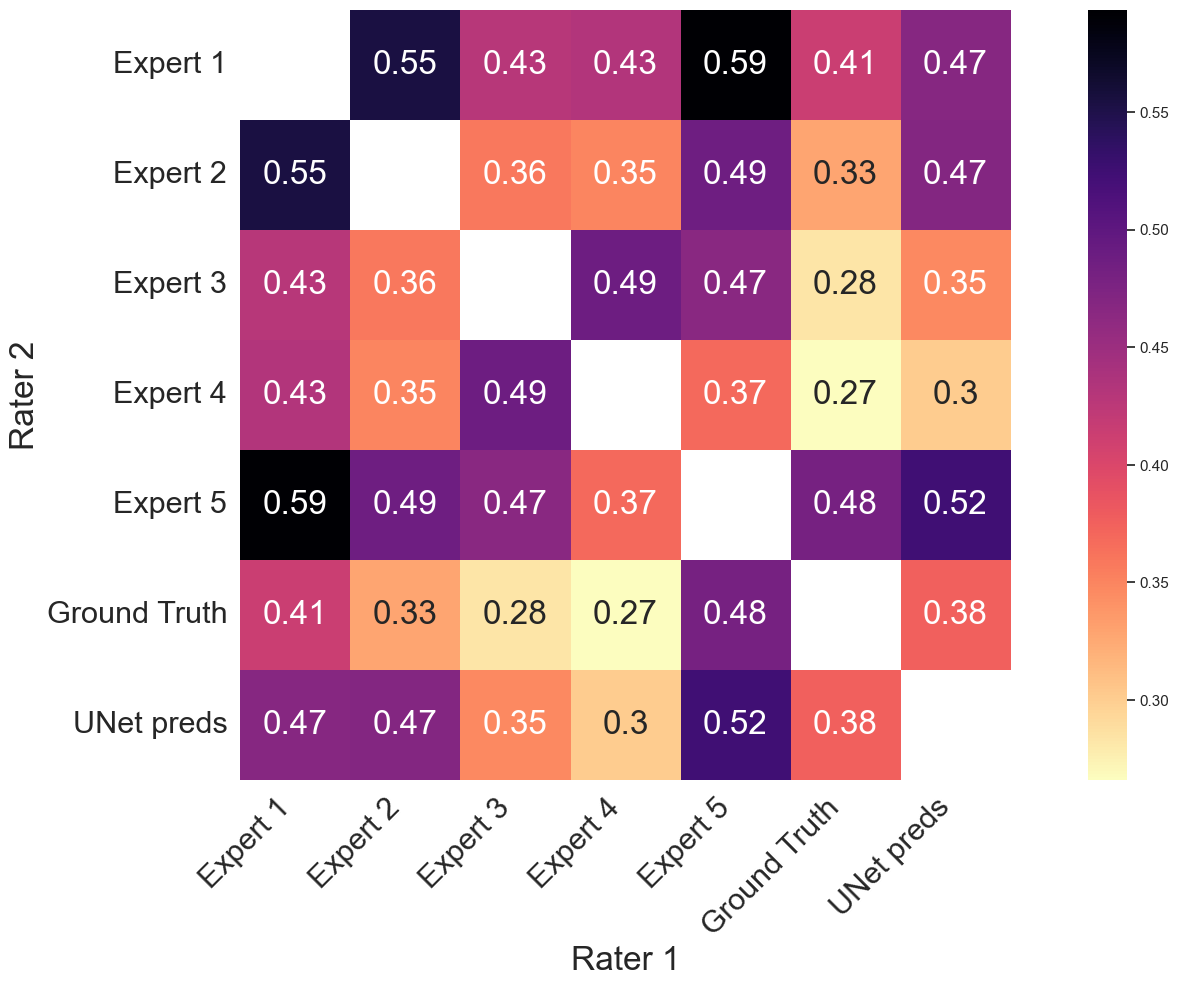

In [40]:
# compute average kappa values over all slices and plot heatmap
avg_kappa_df = kappa_df.pivot_table(index='annotator_1', 
                                    columns='annotator_2', 
                                    values='kappa', 
                                    aggfunc='mean')


plt.figure(figsize = (20,10))

ax = sns.heatmap(avg_kappa_df, annot=True, cmap=sns.color_palette("magma_r", as_cmap=True), annot_kws={"size": 24}, square=True)
ax.set_xlabel('Rater 1', fontsize = 24)
ax.set_ylabel('Rater 2', fontsize = 24)

tick_labels = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Expert 5', 'Ground Truth', 'UNet preds']
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=22)
ax.set_yticklabels(tick_labels, rotation=0, ha='right', fontsize=22)


[Text(0, 0.5, 'Expert 1'),
 Text(0, 1.5, 'Expert 2'),
 Text(0, 2.5, 'Expert 3'),
 Text(0, 3.5, 'Expert 4'),
 Text(0, 4.5, 'Expert 5'),
 Text(0, 5.5, 'UNet preds')]

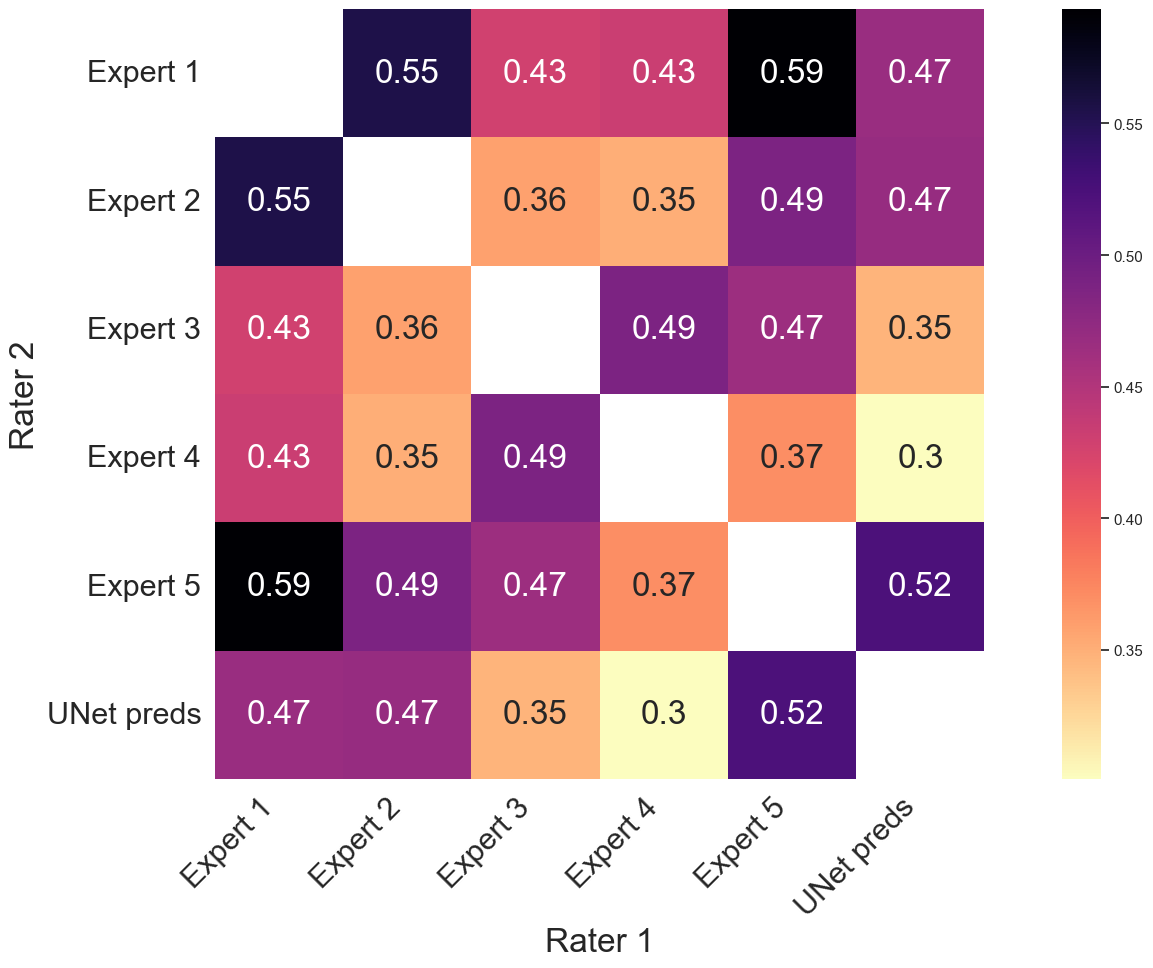

In [41]:
# same as before but without ground truth
avg_kappa_df_no_gt = kappa_df_no_gt.pivot_table(index='annotator_1', 
                                    columns='annotator_2', 
                                    values='kappa', 
                                    aggfunc='mean')


plt.figure(figsize = (20,10))

ax = sns.heatmap(avg_kappa_df_no_gt, annot=True, cmap=sns.color_palette("magma_r", as_cmap=True), annot_kws={"size": 24}, square=True)
ax.set_xlabel('Rater 1', fontsize = 24)
ax.set_ylabel('Rater 2', fontsize = 24)

tick_labels = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Expert 5', 'UNet preds']
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=22)
ax.set_yticklabels(tick_labels, rotation=0, ha='right', fontsize=22)

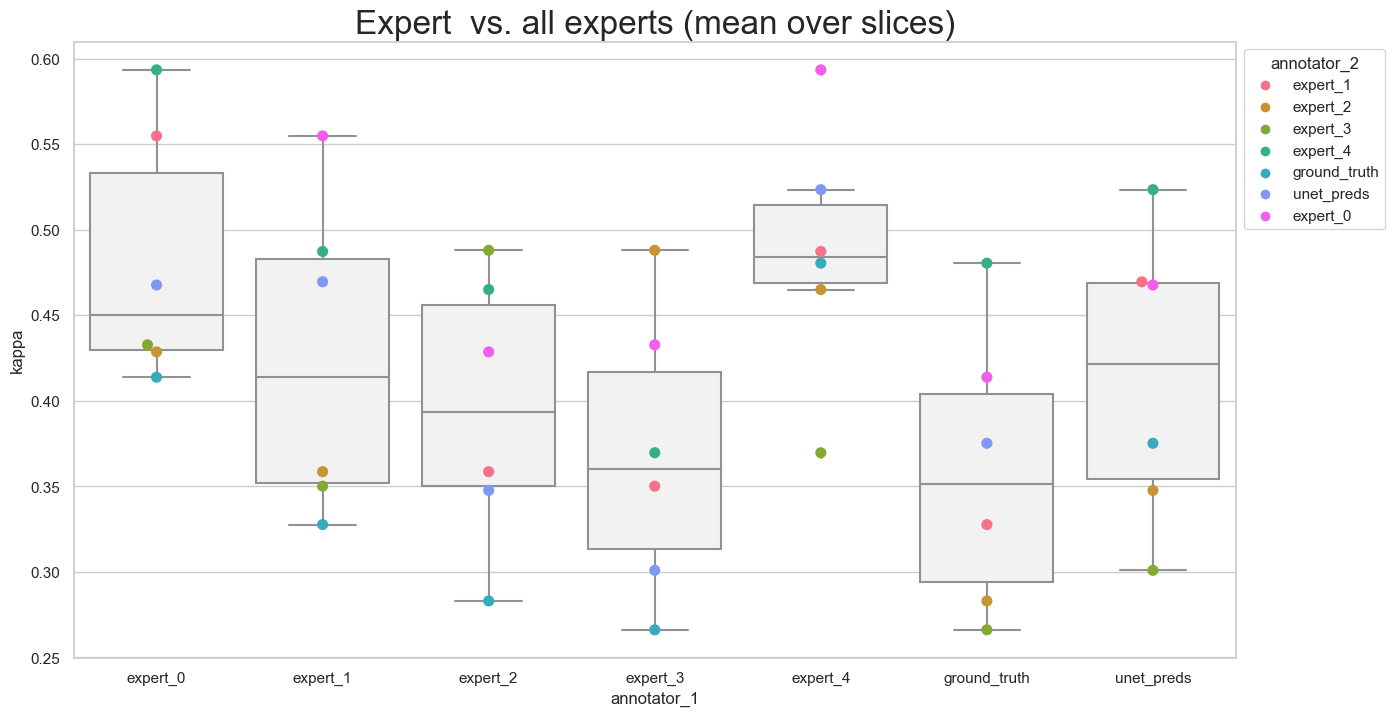

In [42]:
# compute average kappa values over all slices in a new dataframe without slice column
slices_avg_df = kappa_df.groupby(['annotator_1', 'annotator_2']).mean(numeric_only=True).reset_index()

plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="annotator_1", y="kappa", data=slices_avg_df, color='.95')
ax = sns.swarmplot(x="annotator_1", y="kappa", data=slices_avg_df, hue="annotator_2", palette="husl", size=8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Expert  vs. all experts (mean over slices)", fontsize=24)

plt.show()


## Majority vote

TODO: decide whether include ground truth in majority vote of experts or not...

In [43]:
# compute majority vote among all annotators except for unet_preds and ground truth
all_majority_votes = {}
for slice_id in slices_ids:
    all_majority_votes[slice_id] = {}
    for expert in all_segmentations.keys():
        # compute majority vote for all experts and for all experts except for one
        
        if expert == 'unet_preds':
            # compute majority vote for all experts
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ['ground_truth','unet_preds']:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(count_votes, 
                                                                    axis=0, keepdims=False)[0]
        
        elif expert not in ['ground_truth','unet_preds']:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ['ground_truth','unet_preds',expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(count_votes, 
                                                                    axis=0, keepdims=False)[0]   

# same but including unet_preds in majority vote
all_majority_votes_unet = {}
for slice_id in slices_ids:
    
    all_majority_votes_unet[slice_id] = {}
    for expert in all_segmentations.keys():
       
        if expert not in ['ground_truth']:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                
                if other_expert not in ['ground_truth',expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            
            all_majority_votes_unet[slice_id][expert] = scipy.stats.mode(count_votes, 
                                                                    axis=0, keepdims=False)[0]       
            

In [44]:
# for each slice, for each expert and UNet, compute kappa and jaccard_average wrt majority vote

majority_list = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != 'ground_truth':
            majority_list.append({'slice_id': slice_id, 
                                  'Rater': expert,
                                  'Majority': 'majority_vote_wrt_'+expert,
                                  'Kappa': cohen_kappa_score(all_majority_votes[slice_id][expert].flatten(),
                                                             all_segmentations[expert][slice_id].flatten())
                                  })
            
# same but including unet_preds in majority vote
majority_list_unet = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != 'ground_truth':
            majority_list_unet.append({'slice_id': slice_id, 
                                  'Rater': expert,
                                  'Majority': 'majority_vote_wrt_'+expert,
                                  'Kappa': cohen_kappa_score(all_majority_votes_unet[slice_id][expert].flatten(),
                                                             all_segmentations[expert][slice_id].flatten())
                                  })    

In [45]:
majority_df = pd.DataFrame(majority_list)
majority_df_unet = pd.DataFrame(majority_list_unet)

In [46]:
majority_df#.sort_values(by=['Rater','slice_id'])

,slice_id,Rater,Majority,Kappa
0,01,expert_0,majority_vote_wrt_expert_0,0.249188
1,01,expert_1,majority_vote_wrt_expert_1,0.224270
2,01,expert_2,majority_vote_wrt_expert_2,0.405070
3,01,expert_3,majority_vote_wrt_expert_3,0.022866
4,01,expert_4,majority_vote_wrt_expert_4,0.344311
5,01,unet_preds,majority_vote_wrt_unet_preds,0.681886
6,02,expert_0,majority_vote_wrt_expert_0,0.312115
7,02,expert_1,majority_vote_wrt_expert_1,0.241072
8,02,expert_2,majority_vote_wrt_expert_2,0.328834
9,02,expert_3,majority_vote_wrt_expert_3,0.166143


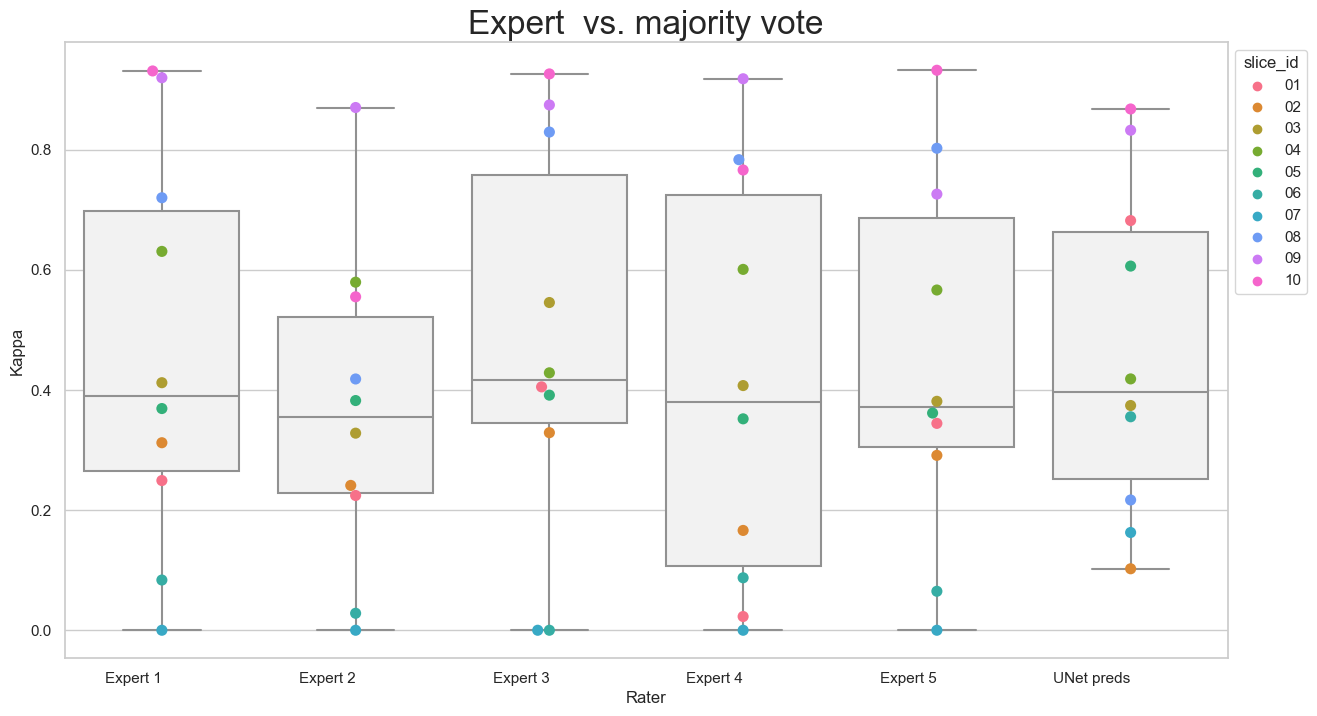

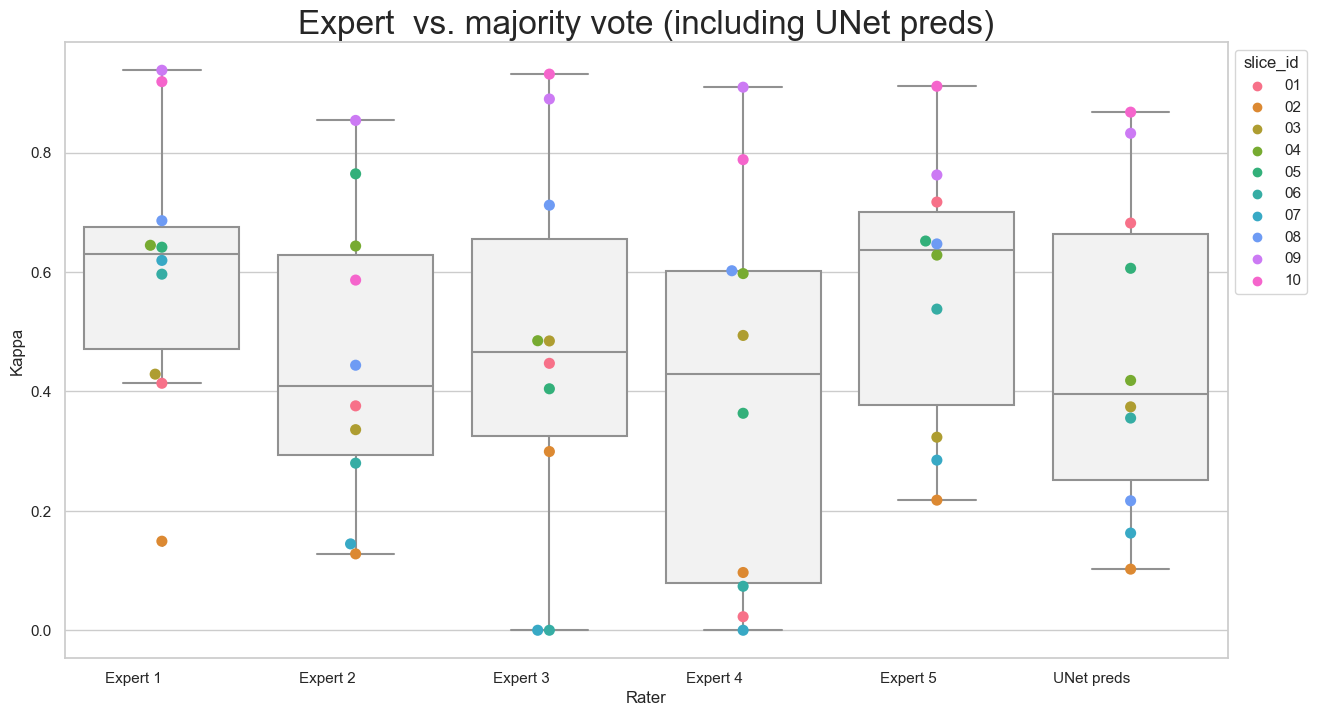

In [47]:
# plot kappa values for each annotator wrt majority vote
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="Rater", y="Kappa", data=majority_df, color='.95')
ax = sns.swarmplot(x="Rater", y="Kappa", data=majority_df, hue="slice_id", palette="husl", size=8)#, color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Expert 5', 'UNet preds']
ax.set_xticklabels(tick_labels, ha='right')

plt.title("Expert  vs. majority vote", fontsize=24)

plt.show()

# plot kappa values for each annotator wrt majority vote including unet_preds
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="Rater", y="Kappa", data=majority_df_unet, color='.95')
ax = sns.swarmplot(x="Rater", y="Kappa", data=majority_df_unet, hue="slice_id", palette="husl", size=8)#, color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Expert 5', 'UNet preds']
ax.set_xticklabels(tick_labels, ha='right')

plt.title("Expert  vs. majority vote (including UNet preds)", fontsize=24)

plt.show()

In [50]:
# don't use mean and std but median and var because
# I am assuming that the distribution is not normal!

In [48]:
majority_df.groupby('Rater').agg({'Kappa': ['median', 'var']})

Kappa          
              median       var
Rater                         
expert_0    0.390521  0.106633
expert_1    0.355180  0.069260
expert_2    0.416780  0.108876
expert_3    0.379569  0.116147
expert_4    0.371286  0.093984
unet_preds  0.396210  0.074531

In [49]:
majority_df_unet.groupby('Rater').agg({'Kappa': ['median', 'var']})

Kappa          
              median       var
Rater                         
expert_0    0.630404  0.054931
expert_1    0.409797  0.062454
expert_2    0.465740  0.102595
expert_3    0.428518  0.111170
expert_4    0.637589  0.050899
unet_preds  0.396210  0.074531

### Compute kruskal-wallis test

In [51]:
from scipy.stats import kruskal

In [52]:
# get dataframe of kappa values for each annotator wrt majority vote
majority_df_pivot = majority_df.pivot(index='Rater', columns='slice_id', values='Kappa')
majority_df_unet_pivot = majority_df_unet.pivot(index='Rater', columns='slice_id', values='Kappa')

In [53]:
# compute kruskal-wallis test for all annotators
stat, p = kruskal(*majority_df_pivot.values.tolist())
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1.016, p=0.961


In [54]:
# compute kruskal-wallis test for all annotators when unet is included in majority vote
stat_unet, p_unet = kruskal(*majority_df_unet_pivot.values.tolist())
print('Statistics=%.3f, p=%.3f' % (stat_unet, p_unet))

Statistics=4.294, p=0.508


In [68]:
import scikit_posthocs as sp

p_adjustment = 'holm'  # "holm"  # bonferroni

pvalues = sp.posthoc_dunn(majority_df_pivot.values.tolist(),
                          p_adjust=p_adjustment
                          )
pvalues_unet = sp.posthoc_dunn(majority_df_unet_pivot.values.tolist(),
                               p_adjust=p_adjustment
                               )

print("p values for each annotator wrt majority vote")
print(pvalues)

print("p values for each annotator wrt majority vote (including unet_preds)")
print(pvalues_unet)

p values for each annotator wrt majority vote
     1    2    3    4    5    6
1  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0
p values for each annotator wrt majority vote (including unet_preds)
     1    2    3    4    5    6
1  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0


### Check if UNet is non-inferior to experts' mean

In [66]:
# compute average jaccard index for each annotator (without unet_preds) wrt majority vote
majority_df_pivot_t = majority_df.pivot(index='slice_id', columns='Rater', values='Kappa')
# compute mean for all experts
majority_df_pivot_t['expert_mean'] = majority_df_pivot_t[['expert_0',
                                                          'expert_1',
                                                          'expert_2',
                                                          'expert_3',
                                                          'expert_4']].mean(axis=1)

display(majority_df_pivot_t)

# compute average jaccard index for each annotator (including unet_preds) wrt majority vote
majority_df_unet_pivot_t = majority_df_unet.pivot(index='slice_id', columns='Rater', values='Kappa')
# compute mean for all experts
majority_df_unet_pivot_t['expert_mean'] = majority_df_unet_pivot_t[['expert_0',
                                                                    'expert_1',
                                                                    'expert_2',
                                                                    'expert_3',
                                                                    'expert_4']].mean(axis=1)

display(majority_df_unet_pivot_t)

Rater,expert_0,expert_1,expert_2,expert_3,expert_4,unet_preds,expert_mean
slice_id,,,,,,,
01,0.249188,0.224270,0.405070,0.022866,0.344311,0.681886,0.249141
02,0.312115,0.241072,0.328834,0.166143,0.291092,0.102337,0.267851
03,0.412023,0.328030,0.545480,0.407248,0.381054,0.374074,0.414767
04,0.630567,0.579323,0.428491,0.600644,0.566310,0.418346,0.561067
05,0.369019,0.382329,0.391317,0.351890,0.361519,0.606128,0.371215
06,0.083591,0.028249,0.000000,0.087327,0.064874,0.355329,0.052808
07,0.000000,0.000000,0.000000,0.000000,0.000000,0.162712,0.000000
08,0.719858,0.418234,0.829215,0.783234,0.802240,0.216813,0.710556
09,0.919594,0.870050,0.874313,0.917922,0.725911,0.832229,0.861558


Rater,expert_0,expert_1,expert_2,expert_3,expert_4,unet_preds,expert_mean
slice_id,,,,,,,
01,0.413598,0.375769,0.446990,0.022683,0.717081,0.681886,0.395224
02,0.149095,0.127866,0.299276,0.096711,0.217875,0.102337,0.178165
03,0.428852,0.335907,0.484490,0.493698,0.323266,0.374074,0.413242
04,0.644673,0.643443,0.484851,0.597306,0.628229,0.418346,0.599700
05,0.641451,0.764303,0.404349,0.363339,0.651804,0.606128,0.565049
06,0.596290,0.279798,0.000000,0.073655,0.537791,0.355329,0.297507
07,0.619357,0.144630,0.000000,0.000000,0.284860,0.162712,0.209770
08,0.685858,0.443826,0.711815,0.602030,0.646949,0.216813,0.618096
09,0.937782,0.853767,0.889631,0.909406,0.762414,0.832229,0.870600


In [71]:
# compute if unet_preds is non-inferior to expert_mean
# https://mverbakel.github.io/2021-02-24/non-inferiority-test
# https://docs.scipy.org/doc/scipy/reference/stats.html

from scipy.stats import ttest_ind

def non_inferiority_ttest(group1, group2, equal_variance=False, increase_good=True):
    '''
    Perform a one-sided t-test with a non-inferiority threshold for two independent samples.
    equal_variance: if False, uses Welch's t-test.
    increase_good: if True, Ho: mean2 <= mean1 - threshold. Else Ho: mean2 >= mean1 + threshold.
    Returns: 
    '''

    tstat, pval = ttest_ind(a=group1, b=group2,
                            equal_var=equal_variance)

    if increase_good:
        pvalue = pval/2.0
    else:
        pvalue = 1 - pval/2.0
    
    return tstat, pvalue

# compute if unet_preds is non-inferior to expert_mean
tstat, pvalue = non_inferiority_ttest(group1=majority_df_unet_pivot_t['unet_preds'],
                                        group2=majority_df_unet_pivot_t['expert_mean'],
                                        equal_variance=False,
                                        increase_good=True)

print("tstat: ", tstat)
print("pvalue: ", pvalue)



tstat:  -0.3103803788868504
pvalue:  0.37994687208104266


In [ ]:
# OLD COMPARISON
# compute kappa values between majority vote and unet_preds, and bewteen majority vote and ground truth
# majority_list = []
# for slice_id in slices_ids:
#     majority_list.append({'slice_id': slice_id,
#                     'Majority': 'majority_vote',
#                     'Rater': 'unet_preds',
#                     'Kappa': cohen_kappa_score(majority_vote[slice_id].flatten(), 
#                                                all_segmentations['unet_preds'][slice_id].flatten())})
#     majority_list.append({'slice_id': slice_id,
#                     'Majority': 'majority_vote',
#                     'Rater': 'ground_truth',
#                     'Kappa': cohen_kappa_score(majority_vote[slice_id].flatten(), 
#                                                all_segmentations['ground_truth'][slice_id].flatten())})
    
# majority_df = pd.DataFrame(majority_list)


# OLD COMPARISON
# compute jaccard_average values between majority vote and unet_preds, and bewteen majority vote and ground truth
# majority_list = []
# for slice_id in slices_ids:
#     # compute jaccaard similarity for each class
#     jaccard_0, jaccard_1, jaccard_2, jaccard_3 = jaccard_score(majority_vote[slice_id].flatten(),
#                                                                all_segmentations['unet_preds'][slice_id].flatten(),
#                                                                labels=[0,1,2,3], average=None)
#     jaccard_average_unet = np.mean([jaccard_1, jaccard_2, jaccard_3])

#     jaccard_0, jaccard_1, jaccard_2, jaccard_3 = jaccard_score(majority_vote[slice_id].flatten(),
#                                                                all_segmentations['ground_truth'][slice_id].flatten(),
#                                                                labels=[0,1,2,3], average=None)
#     jaccard_average_gt = np.mean([jaccard_1, jaccard_2, jaccard_3])

#     majority_list.append({'slice_id': slice_id,
#                     'Majority': 'majority_vote',
#                     'Rater': 'unet_preds',
#                     'Jaccard Average': jaccard_average_unet})
#     majority_list.append({'slice_id': slice_id,
#                     'Majority': 'majority_vote',
#                     'Rater': 'ground_truth',
#                     'Jaccard Average': jaccard_average_gt})
    
# majority_df_jaccard = pd.DataFrame(majority_list)
# OLD COMPARISON
# visualize kappa values for majority vote and visualize if difference is significant
# plt.figure(figsize = (12,10))

# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(x="Rater",
#                  y="Kappa",
#                  data=majority_df,
#                  palette="PRGn")
# ax.set_ylim(0, 1)
# ax.tick_params(axis='both', which='major', labelsize=24)
# ax.set_xticklabels(['UNet preds', 'Ground Truth'], rotation=0)
# ax.set_xlabel('Rater', fontsize=24)
# ax.set_ylabel('Agreement with majority vote (kappa)', fontsize=24)
# OLD COMPARISON
# visualize jaccard_average values for majority vote and visualize if difference is significant
# plt.figure(figsize = (12,10))

# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(x="Rater",
#                  y="Jaccard Average",
#                  data=majority_df_jaccard,
#                  palette="PRGn")
# ax.set_ylim(0, 1)
# ax.tick_params(axis='both', which='major', labelsize=24)
# ax.set_xticklabels(['UNet preds', 'Ground Truth'], rotation=0)
# ax.set_xlabel('Rater', fontsize=24)
# ax.set_ylabel('Agreement with majority vote (Jaccard average)', fontsize=24)

## Visualize sample frame and annotations

In [42]:
anon_ids

{'RJ': 'expert_0',
 'ME': 'expert_1',
 'EN': 'expert_2',
 'NS': 'expert_3',
 'MW': 'expert_4'}

In [39]:
rater_ids = ['ground_truth', 'unet_preds'] + list(anon_ids.values())
rater_ids

['ground_truth',
 'unet_preds',
 'expert_0',
 'expert_1',
 'expert_2',
 'expert_3',
 'expert_4']

In [292]:
sample_id = '07'

<>:73: DeprecationWarning: invalid escape sequence \s
<>:73: DeprecationWarning: invalid escape sequence \s
C:\Users\dotti\AppData\Local\Temp\ipykernel_17740\3492481215.py:73: DeprecationWarning: invalid escape sequence \s
  fig.savefig(save_path+f"\segmentation_sample_{sample_id}.png", bbox_inches='tight')


ground_truth: [0 1 3]
unet_preds: [0 1 3]
expert_0: [0 1]
expert_1: [0 1]
expert_2: [0]
expert_3: [0]
expert_4: [0 1]


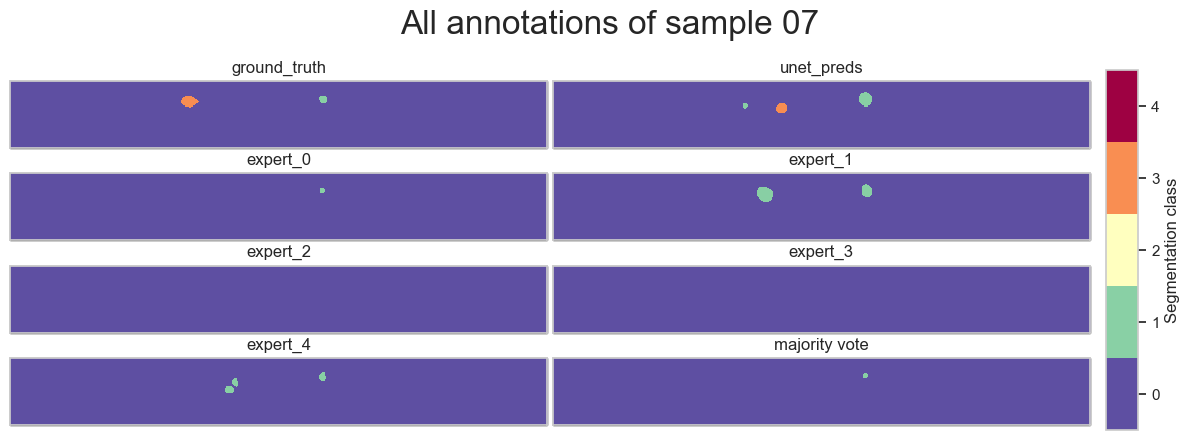

In [293]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# get colormap
cmap = plt.get_cmap('Spectral_r', data_max - data_min + 1)

ncol = 2
nrow = math.ceil((len(rater_ids)+1)/2)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, 
                         figsize=(16, 6))

for i, ax in enumerate(axes.flat):
    if i < len(rater_ids):
        # show segmentation
        ax.set_title(rater_ids[i])
        data = all_segmentations[rater_ids[i]][sample_id]
        im = ax.imshow(data,
                       cmap=cmap,
                       interpolation="nearest",
                       vmin=data_min-0.5,
                       vmax=data_max+0.5)

        # add black border to subplot
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(1)

        # remove ticks from subplot  
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # remove grid from subplot
        ax.grid(False)

        print(f"{rater_ids[i]}: {np.unique(all_segmentations[rater_ids[i]][sample_id])}")
    elif i == len(rater_ids):
        # show majority vote
        ax.set_title('majority vote')
        data = all_majority_votes[sample_id]['unet_preds']
        im = ax.imshow(data,
                        cmap=cmap,
                        interpolation="nearest",
                        vmin=data_min-0.5,
                        vmax=data_max+0.5)

        # add black border to subplot
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(1)

        # remove ticks from subplot  
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # remove grid from subplot
        ax.grid(False)
    else:
        ax.axis('off')

fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax, 
                    ticks=np.arange(data_min, data_max + 1), label='Segmentation class')

fig.suptitle(f'All annotations of sample {sample_id}', fontsize=24, y=0.9)

plt.show()

# save figure
save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
fig.savefig(save_path+f"\segmentation_sample_{sample_id}.png", bbox_inches='tight')

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

### Majority vote

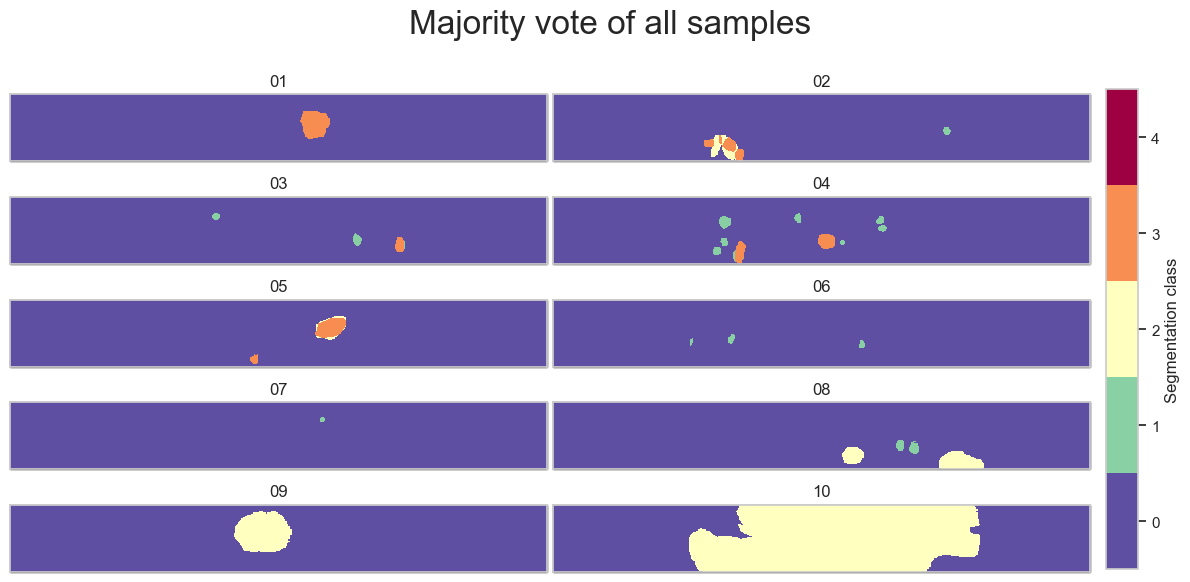

In [121]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# get colormap
cmap = plt.get_cmap('Spectral_r', data_max - data_min + 1)

ncol = 2
nrow = math.ceil(len(slices_ids)/2)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, 
                         figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    # show majority vote segmentation
    ax.set_title(slices_ids[i])
    data = all_majority_votes[slices_ids[i]]['unet_preds']
    im = ax.imshow(data,
                    cmap=cmap,
                    interpolation="nearest",
                    vmin=data_min-0.5,
                    vmax=data_max+0.5)

    # add black border to subplot
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1)

    # remove ticks from subplot  
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # remove grid from subplot
    ax.grid(False)

fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax, 
                    ticks=np.arange(data_min, data_max + 1), label='Segmentation class')

fig.suptitle(f'Majority vote of all samples', fontsize=24, y=0.9)

plt.show()

### Visualize original frames

In [151]:
# Load original frames
frames_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices"

frames = {}
for sample_id in slices_ids:
    frame_id = slice_to_frame_id[sample_id]+1
    frames[sample_id] = np.asarray(imageio.imread(frames_dir + f"\\sample{sample_id}_slice{frame_id:03}.tif"))

C:\Users\dotti\AppData\Local\Temp\ipykernel_17740\2737114704.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames[sample_id] = np.asarray(imageio.imread(frames_dir + f"\\sample{sample_id}_slice{frame_id:03}.tif"))
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: Typ

<>:13: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
C:\Users\dotti\AppData\Local\Temp\ipykernel_17740\1490251665.py:13: DeprecationWarning: invalid escape sequence \o
  fig.savefig(save_path+f"\original_frame_sample_{sample_id}.png", bbox_inches='tight')


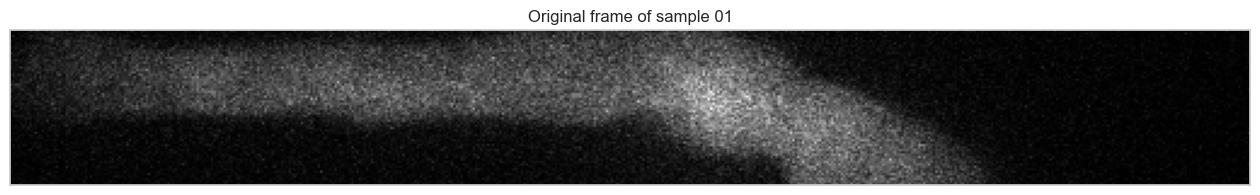

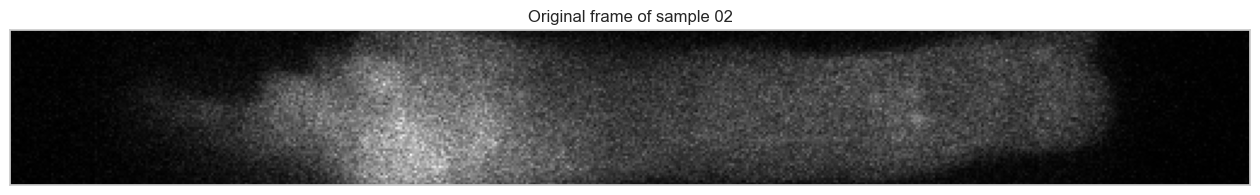

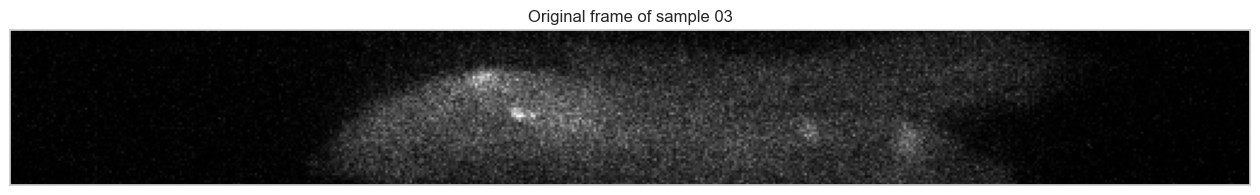

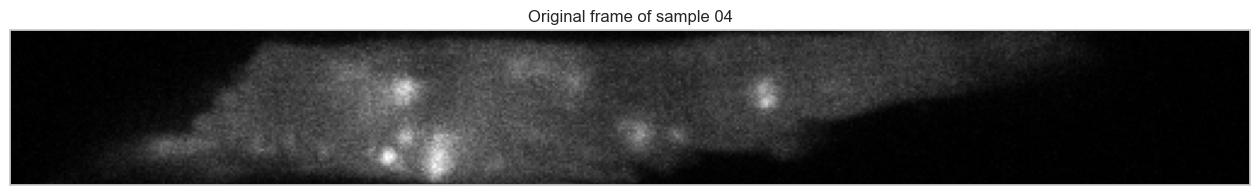

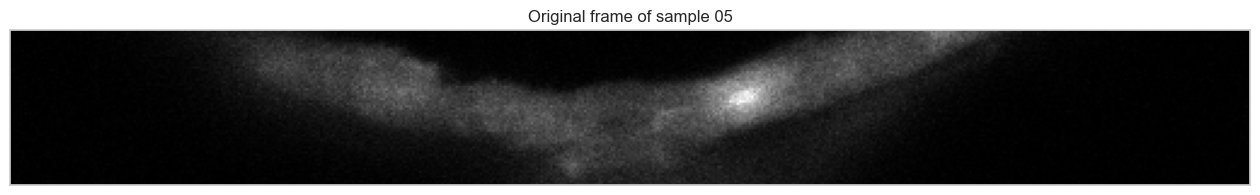

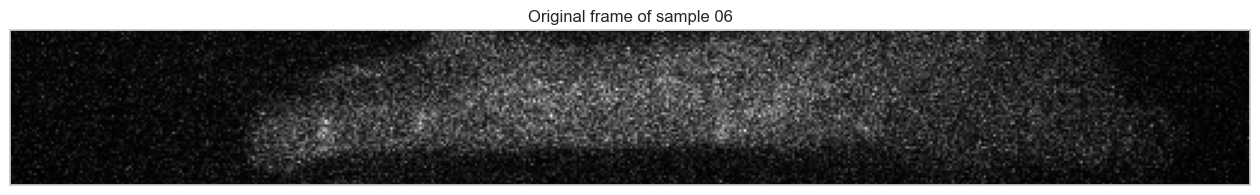

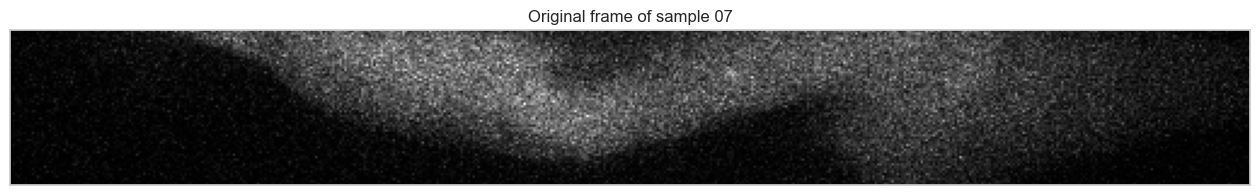

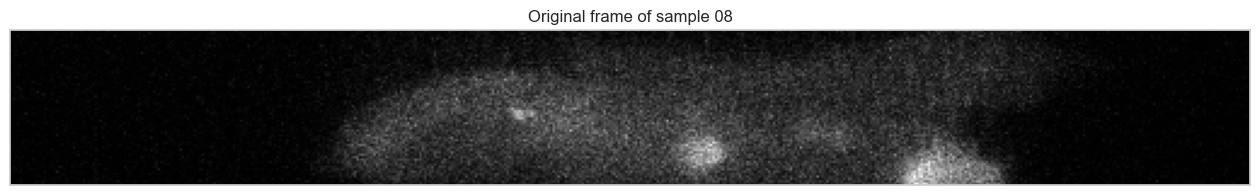

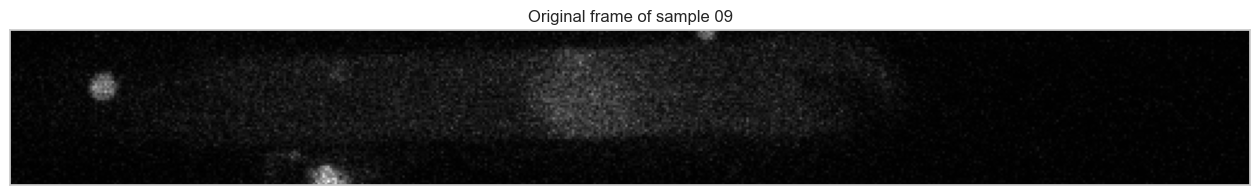

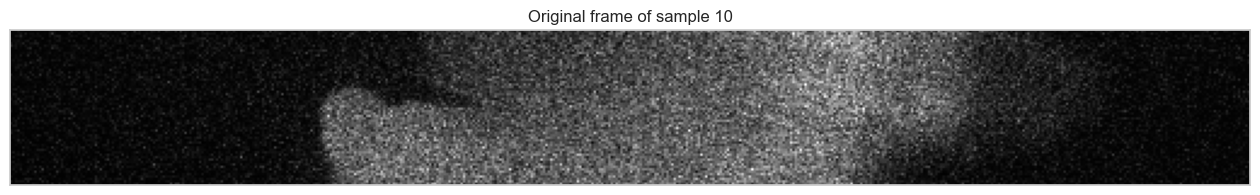

In [153]:
# plot original frames
for sample_id in slices_ids:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(frames[sample_id], cmap='gray')
    ax.set_title(f'Original frame of sample {sample_id}')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    plt.show()

    # save original frames
    save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
    fig.savefig(save_path+f"\original_frame_sample_{sample_id}.png", bbox_inches='tight')

### Visualize all majority votes of a given frame

In [294]:
frame_id = '07'

expert_0: [0]
expert_1: [0]
expert_2: [0 1]
expert_3: [0 1]
expert_4: [0]
unet_preds: [0 1]


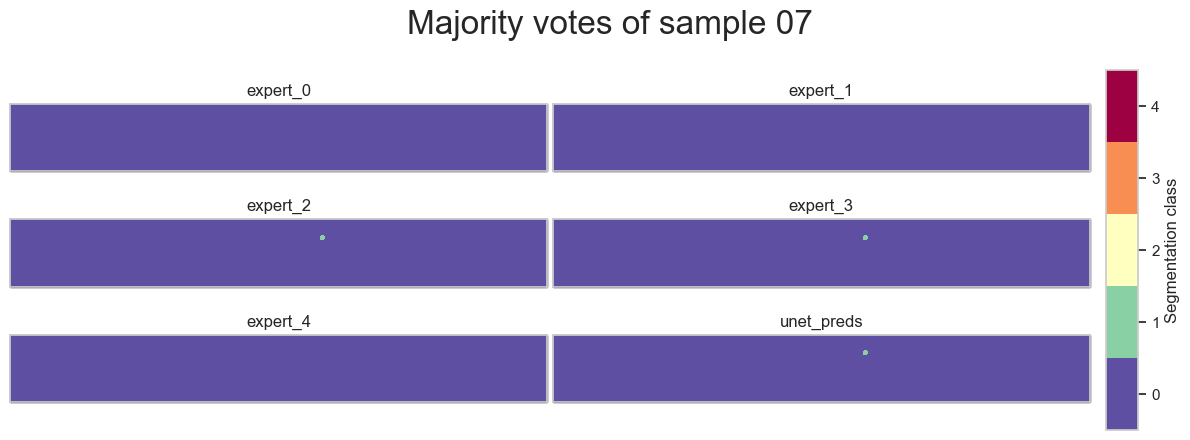

In [314]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# get colormap
cmap = plt.get_cmap('Spectral_r', data_max - data_min + 1)

# get list of raters for which majority vote is available
majority_rater_ids = list(all_majority_votes[frame_id].keys())

ncol = 2
nrow = math.ceil((len(majority_rater_ids))/2)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, 
                         figsize=(16, 6))

for i, ax in enumerate(axes.flat):
    if i < len(majority_rater_ids):
        # show segmentation
        ax.set_title(majority_rater_ids[i])
        data = all_majority_votes[frame_id][majority_rater_ids[i]]
        im = ax.imshow(data,
                       cmap=cmap,
                       interpolation="nearest",
                       vmin=data_min-0.5,
                       vmax=data_max+0.5)

        # add black border to subplot
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(1)

        # remove ticks from subplot  
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # remove grid from subplot
        ax.grid(False)

        print(f"{majority_rater_ids[i]}: {np.unique(data)}")
    else:
        ax.axis('off')

fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax, 
                    ticks=np.arange(data_min, data_max + 1), label='Segmentation class')

fig.suptitle(f'Majority votes of sample {frame_id}', fontsize=24, y=0.9)

plt.show()

# save figure
#save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
#fig.savefig(save_path+f"\segmentation_sample_{sample_id}.png", bbox_inches='tight')

In [312]:
np.unique(all_majority_votes[frame_id]['expert_1'])

array([0], dtype=uint16)